<a href="https://colab.research.google.com/github/surya-chak/LearningChem/blob/master/basicSystemIDStuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# System ID part
Todo: 
- [x] Run a basic system ID code and try to learn parameters using gradient descent
- [x] Enable batched optimization to learn from all instance files simultaneously
- [ ] Incorporate differentiable ODE solver to improve ODE solution and thereafter optimize system params
- [ ] Incorporate implicit bias over system parameters so as to respect the conditions about non-zero and sign of parameters across different systems

## Importing libraries and Git repo

In [ ]:
!git clone https://github.com/surya-chak/LearningChem.git

Cloning into 'LearningChem'...
remote: Enumerating objects: 252, done.
remote: Counting objects: 100% (252/252), done.
remote: Compressing objects: 100% (251/251), done.
remote: Total 252 (delta 0), reused 252 (delta 0), pack-reused 0
Receiving objects: 100% (252/252), 402.55 KiB | 9.15 MiB/s, done.


In [ ]:
import numpy as np
import pandas as pd
import os, glob
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Loading data from csv

In [ ]:
def load_from_csv(system_id):
  files = glob.glob(os.path.join('LearningChem','public_data','system_{}*'.format(system_id,instance_id)))
  X_all = []
  T_all = []
  Y_all = []
  U_all = []
  for file in files: 
    df = pd.read_csv(file)
    X = []
    T = []
    Y = []
    U = []
    for k,row in df.iterrows():
      X.append(row[['X{}'.format(k) for k in range(1,15)]].values)
      T.append(row['t'])
      Y.append(row['Y'])
      U.append(row[['U{}'.format(k) for k in range(1,9)]].values)
    U = U[0]
    X_all.append(X)
    T_all.append(T)
    Y_all.append(Y)
    U_all.append(U)
  return np.array(T_all,dtype=np.float),np.array(Y_all,dtype=np.float),np.array(X_all,dtype=np.float),np.array(U_all,dtype=np.float)

In [ ]:
system_id = '01'
# instance_id='00'
T,Y,X,U = load_from_csv(system_id=system_id)
print(T.shape,Y.shape,X.shape,U.shape)
# del_T = np.diff(T)
# print(del_T)
# print(U)

(20, 20) (20, 20) (20, 20, 14) (20, 8)


## Training a neural network parameterization of system

### System forward definition

In [ ]:
class System_F(nn.Module):
  def __init__(self,system_id,state_dim=15,inp_dim=8):
    super().__init__()
    self.system_id = system_id
    self.state_dim = state_dim
    self.inp_dim = inp_dim
    self.linear_NN = nn.Linear(in_features=self.state_dim,out_features=self.state_dim,bias=False)
    self.quadratic_NN = nn.Linear(in_features=self.state_dim**2,out_features=self.state_dim,bias=False)
    self.input_NN = nn.Linear(in_features=self.inp_dim,out_features=self.state_dim,bias=False)

  def forward(self,X,U=None):
    device = next(self.parameters()).device
    if U is None:
      U = torch.zeros(X.shape[0],self.inp_dim)
    assert X.shape[0]==U.shape[0], "Batch size should be same for X ({}) and U ({})".format(X.shape[0],U.shape[0])
    X = X.to(device)
    U = U.to(device)
    linear_out = self.linear_NN(X)
    quadratic_inp = X.unsqueeze(-1)*X.unsqueeze(-2)
    quadratic_out = self.quadratic_NN(quadratic_inp.view(X.shape[0],-1))
    inp_out = self.input_NN(U)
    return linear_out+quadratic_out

F1 = System_F(system_id=1)
X = torch.rand(2,15)
U = torch.rand(2,8)
with torch.no_grad():
  out = F1(X,U)
print(out.shape)

torch.Size([2, 15])


### Training on all instances of a system

T:(20, 20),Y:(20, 20),X:(20, 20, 14),U:(20, 8)



[7.661186192184687, 16.36952133476734, 5.503786139190197, 6.170974858105183, 4.919108957052231, 4.269439358264208, 3.796749383211136, 3.9412564747035503, 3.530412334948778, 3.798909652978182, 2.821563981473446, 2.443360272794962, 2.4563036113977432, 2.430880356580019, 2.619199261069298, 1.9804016426205635, 2.7062458842992783, 2.933468423783779, 3.243971351534128, 3.774737849831581, 3.877307627350092, 3.157635785639286, 3.4617717936635017, 2.82141524925828, 3.2296166829764843]
[12, 15, 16, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18]


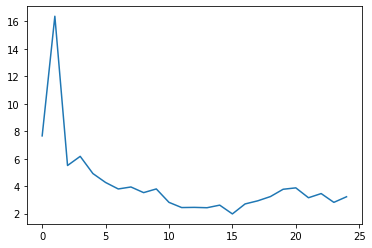

In [ ]:
system_id = '01'
# instance_id = '00'
T,Y,X,U = load_from_csv(system_id=system_id)
print("T:{},Y:{},X:{},U:{}".format(T.shape,Y.shape,X.shape,U.shape))
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model = System_F(system_id=system_id)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),1e-3)
sampling_dt = 0.001
epochs = 25
loss_arr = []
idx_arr = []
for epoch in tqdm(range(epochs)):
  current_time = 0.0
  loss_epoch = 0
  model.train()
  optimizer.zero_grad()
  for idx in range(T.shape[1]-1):
    t = T[0,idx]
    y = torch.Tensor(Y[:,idx]).unsqueeze(-1)
    x = torch.Tensor(X[:,idx])
    # print(y.shape,x.shape)
    state_vec = torch.hstack((y,x))
    if idx<3:
      u = torch.Tensor(U)
    else:
      u = None
    # print(state_vec.shape,u.shape)
    # break
    x_system = state_vec
    while current_time<T[0,idx+1]:
      x_system = x_system + model(x_system,u)*sampling_dt
      current_time += sampling_dt
      # print(current_time)
    target_vec = torch.hstack((torch.Tensor(Y[:,idx+1]).unsqueeze(-1),torch.Tensor(X[:,idx+1])))
    loss = loss_func(x_system,target_vec)
    # print(x_system.data,target_vec.data)
    if np.isnan(loss.item()):
      break
    loss_epoch+= loss.item()
    # print(idx,loss)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(),100)
    optimizer.step()
    optimizer.zero_grad()
  loss_arr.append(loss_epoch)
  idx_arr.append(idx)
  # print(epoch,loss_arr)

plt.plot(loss_arr)
print(loss_arr)
print(idx_arr)

## Incorporate torchdiffeq to improve ODE solver
Todo: 
- [ ] Incorporate [torchdiffeq](https://github.com/rtqichen/torchdiffeq) repo to get solution to ODE
- [ ] Propagate gradients through the ODE solver to update system parameters
- [ ] Incorporate the shared system characteristics across different systems

# RL part
Todo: 
- [ ] Use the learned system parameters to optimize input: gradient-based optimization to minimize the loss (eq. 10 in whitepaper)
- [ ] Look into the formulation of [Information Theoretic MPC paper](https://homes.cs.washington.edu/~bboots/files/InformationTheoreticMPC.pdf) and try to draw some parallels to this problem